# Carregamento dos dados com pandas

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
uri = "machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


Organizando dados de maneira azarada

In [3]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


# Primeiro método, DummyClassifier

Este método faz um "chute" baseado nos mais prováveis

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

def MetodoDummyClassifier(x_todo,y_todo,quantidade_folds_cv):
    SEED = 301
    np.random.seed(SEED)

    modelo = DummyClassifier()
    results = cross_validate(modelo, x_todo, y_todo, cv = quantidade_folds_cv, return_train_score=False)
    media = results['test_score'].mean()
    desvio_padrao = results['test_score'].std()
    print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

In [5]:
MetodoDummyClassifier(x_azar,y_azar,10)

Accuracy com dummy stratified, 10 = [49.79, 53.45]


# Segundo método, DecisionTreeClassifier (max_depth fixo, sem GroupKFold)

Cria uma arvore de decisão

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

def MetodoDecisionTreeClassifierFixo(x_todo,y_todo,quantidade_folds_cv):
    SEED = 301
    np.random.seed(SEED)

    modelo = DecisionTreeClassifier(max_depth=2)
    results = cross_validate(modelo, x_todo, y_todo, cv = quantidade_folds_cv, return_train_score=False)
    media = results['test_score'].mean()
    desvio_padrao = results['test_score'].std()
    print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

In [7]:
MetodoDecisionTreeClassifierFixo(x_azar,y_azar,10)

Accuracy com cross validation, 10 = [73.83, 77.73]


# Aplicando Pipeline (modelo SVC, e agrupamento GroupKFold)

In [8]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador
SEED = 301
np.random.seed(SEED)

dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


Definindo cálculo de resultados 

In [9]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

SVC por sua vez, sofre influência da escala. Devemos escalar somente nos dados de treino para o fit no SVC, para isso utilizamos o Pipeline (sequéncia de passos)  

In [10]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

def MetodoPipelineSVC(x_todo,y_todo,quantidade_folds_cv):

    SEED = 301
    np.random.seed(SEED)

    scaler = StandardScaler()
    modelo = SVC()

    pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

    cv = GroupKFold(n_splits = 10)
    results = cross_validate(pipeline, x_todo, y_todo, cv = quantidade_folds_cv, groups = dados.modelo, return_train_score=False)
    imprime_resultados(results)

In [11]:
MetodoPipelineSVC(x_azar,y_azar,10)

Accuracy médio 76.68
Intervalo [74.04, 79.32]


Comparando com o DecisionTreeClassifier ultilizando GroupKFold

In [12]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


Observando árvore do método

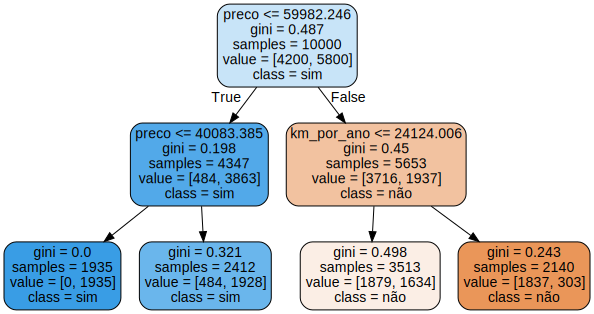

In [13]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

Comparando com uma maior profundidade

In [14]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


# DecisionTreeClassifier com max_depth variável (Sem GridSearchCV)

In [15]:
import time

def MetodoDecisionTreeClassifier_MaxDepth(x_todo,y_todo,quantidade_folds_cv,max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = quantidade_folds_cv)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_todo, y_todo, cv = cv, groups = dados.modelo, return_train_score=True)
    
    # printa o resultado de cada max_depth
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
    tabela = [max_depth, train_score, test_score]
    return tabela
    


In [16]:
tic = time.time()
resultados = [MetodoDecisionTreeClassifier_MaxDepth(x_azar,y_azar,10, i) for i in range(1,33)]
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

resultados = pd.DataFrame(resultados, columns= ["max_depth","train","test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


Analizando o gráfico abaixo, persebse que o método ficou muito bom para o treino, contudo ficou ruim para o teste

In [17]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

# DecisionTreeClassifier com max_depth e min_samples_leaf variável (Sem GridSearchCV)

In [19]:
def MetodoDecisionTreeClassifier_MaxDepth_MinSamplesLeaf(x_todo,y_todo,quantidade_folds_cv,max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = quantidade_folds_cv)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_todo, y_todo, cv = cv, groups = dados.modelo, return_train_score=True)
    
    # printa o resultado de cada max_depth
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela
    

In [20]:
def varredura():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = MetodoDecisionTreeClassifier_MaxDepth_MinSamplesLeaf(x_azar,y_azar,10,max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

In [21]:
tic = time.time()
resultados = varredura()
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

Arvore max_depth = 28, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 28, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 28, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 29, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 29, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 30, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 30, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 31, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [22]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


Gráfico de correlações

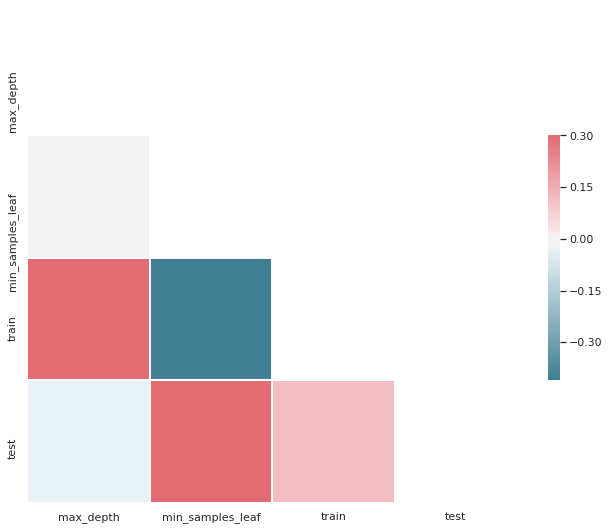

In [23]:
corr = resultados.corr()

# Outro gráfico de correlações
'''
sns.heatmap(corr)
'''

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

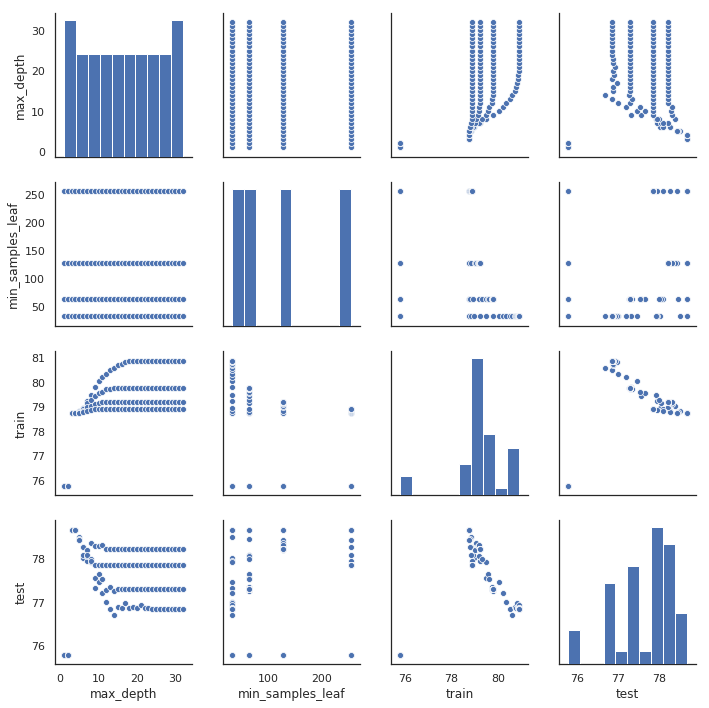

In [24]:
sns.pairplot(resultados)

# Método GridSearchCV com DecisionTreeClassifier

Infelizmente como o Pandas não suporta nested validation com GroupKFold, ultilizarei simplesmente o kFold

In [25]:
from sklearn.model_selection import GridSearchCV, KFold

def Metodo_GridSearchCV_DecisionTreeClassifier(quantidade_folds):

    SEED=301
    np.random.seed(SEED)

    espaco_de_parametros = {
        "max_depth" : [i for i in range(3,5)],
        "min_samples_split" : [32, 64, 128],
        "min_samples_leaf" : [32, 64, 128],
        "criterion" : ["gini", "entropy"]
    }

    metodo = GridSearchCV(DecisionTreeClassifier(),
                            espaco_de_parametros,
                            cv = KFold(n_splits = quantidade_folds, shuffle=True))

    return metodo

In [26]:
busca = Metodo_GridSearchCV_DecisionTreeClassifier(5)

tic = time.time()
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 2.84 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014211,0.002182,0.001965,0.000376,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.787,0.009618,1,0.788375,0.790125,0.783625,0.786,0.7895,0.787525,0.002405
1,0.009974,0.000496,0.001356,0.000114,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.787,0.009618,1,0.788375,0.790125,0.783625,0.786,0.7895,0.787525,0.002405
2,0.008476,0.000390,0.001142,0.000085,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.787,0.009618,1,0.788375,0.790125,0.783625,0.786,0.7895,0.787525,0.002405
3,0.008373,0.000272,0.001235,0.000221,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.787,0.009618,1,0.788375,0.790125,0.783625,0.786,0.7895,0.787525,0.002405
4,0.008293,0.000442,0.001237,0.000215,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,...,0.787,0.009618,1,0.788375,0.790125,0.783625,0.786,0.7895,0.787525,0.002405


Como foi minha busca

In [27]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [28]:
from sklearn.model_selection import cross_val_score

tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)

Tempo 11.66 segundos
Accuracy médio 78.67
Intervalo [76.80, 80.54]


Melhor modelo

In [29]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Analizando dados do melhor modelo

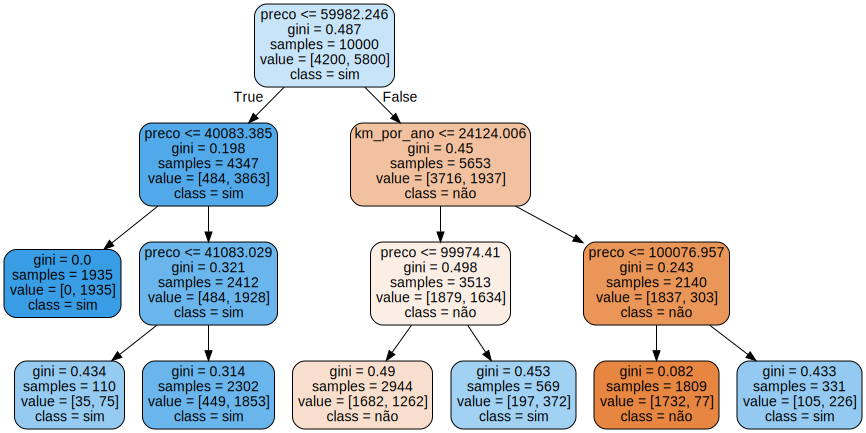

In [30]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

# Busca aleatória: RandomSearch (DecisionTreeClassifier)

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def MetodoRandomizedSearchCV(numero_splits,numero_amostras):

    SEED=564
    np.random.seed(SEED)

    espaco_de_parametros = {
        "max_depth" : [3, 5, 10, 15, 20, 30, None],
        "min_samples_split" : randint(32, 128),
        "min_samples_leaf" : randint(32, 128),
        "criterion" : ["gini", "entropy"]
    }

    metodo = RandomizedSearchCV(DecisionTreeClassifier(),
                        espaco_de_parametros,
                        n_iter = numero_amostras,
                        cv = KFold(n_splits = numero_splits, shuffle=True),
                        random_state = SEED)
    return metodo 

In [32]:
busca = MetodoRandomizedSearchCV(5,64)

tic = time.time()
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 8.03 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.034700,0.007095,0.001598,0.000300,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7780,...,0.7701,0.006583,62,0.795000,0.796000,0.797000,0.794125,0.794625,0.795350,0.001029
1,0.008162,0.000311,0.001261,0.000368,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,...,0.7869,0.005607,1,0.786500,0.787750,0.786500,0.786750,0.790125,0.787525,0.001379
2,0.014063,0.000623,0.001421,0.000391,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7775,...,0.7780,0.005273,18,0.794125,0.793000,0.795750,0.791125,0.794250,0.793650,0.001536
3,0.030219,0.001123,0.001496,0.000423,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7710,...,0.7711,0.005295,57,0.799375,0.800375,0.801125,0.800250,0.802125,0.800650,0.000923
4,0.015753,0.000532,0.001311,0.000258,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7755,...,0.7760,0.004669,29,0.797500,0.798750,0.795375,0.796625,0.796875,0.797025,0.001105


In [33]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.786 +-(0.013) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.786 +-(0.013) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.786 +-(0.014) {'criterion': 'entropy', 'max_depth': 5, 

Avaliar melhores parametros

In [34]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 31.49 segundos
Accuracy médio 78.69
Intervalo [77.64, 79.74]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=53, min_samples_split=60,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


# Busca aleatória: RandomSearch (RandomForestClassifier)

In [35]:
from sklearn.ensemble import RandomForestClassifier

def MetodoRandomSearch_RandomForestClassifier(numero_splits,numero_amostras):

    SEED=301
    np.random.seed(SEED)

    espaco_de_parametros = {
        "n_estimators" :randint(10, 101),
        "max_depth" : randint(3, 6),
        "min_samples_split" : randint(32, 129),
        "min_samples_leaf" : randint(32, 129),
        "bootstrap" : [True, False],
        "criterion" : ["gini", "entropy"]
}

    metodo = RandomizedSearchCV(RandomForestClassifier(),
                        espaco_de_parametros,
                        n_iter = numero_amostras,
                        cv = KFold(n_splits = numero_splits, shuffle=True))
    
    return metodo

In [36]:
busca = MetodoRandomSearch_RandomForestClassifier(5,80)

tic = time.time()
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 110.03 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.330164,0.027337,0.022639,0.001766,False,gini,3,50,93,89,...,0.7704,0.009744,75,0.777625,0.776125,0.761500,0.773625,0.780625,0.773900,0.006601
1,0.240949,0.001396,0.021598,0.000561,True,gini,3,88,104,80,...,0.7729,0.014277,63,0.777125,0.772875,0.771500,0.773375,0.779875,0.774950,0.003088
2,0.228751,0.002586,0.021808,0.000420,True,gini,3,126,84,77,...,0.7735,0.011781,59,0.773750,0.777500,0.771500,0.775875,0.780750,0.775875,0.003164
3,0.143085,0.009669,0.013205,0.000872,True,gini,3,57,73,50,...,0.7733,0.010429,60,0.777250,0.778000,0.764125,0.773625,0.780500,0.774700,0.005727
4,0.205356,0.002498,0.017412,0.000528,True,gini,4,52,88,68,...,0.7754,0.012220,28,0.777625,0.778250,0.771625,0.774625,0.780375,0.776500,0.003054


Observar resultados

In [37]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.779 +-(0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +-(0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.777 +-(0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +-(0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


In [38]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 497.17 segundos
Accuracy médio 77.24
Intervalo [75.49, 78.99]
RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=84,
            min_samples_split=89, min_weight_fraction_leaf=0.0,
            n_estimators=48, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


# Caso não possa usar cross validation (pouco processamento)

É preciso separar os dados em três partes: treino, teste e validação. Pois o train_test_split nao faz isso, diferentimente do KFolds (esse método é menos confiavel para a realidade)

In [39]:
# 0.6 treino     => treino
# 0.2 teste      => dev teste
# 0.2 validacao  => validacao

from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)
print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)


(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

def MetodoRandomizedSearchCV_PoucoPrecessamento(numero_splits,numero_amostras):

    espaco_de_parametros = {
        "n_estimators" :randint(10, 101),
        "max_depth" : randint(3, 6),
        "min_samples_split" : randint(32, 129),
        "min_samples_leaf" : randint(32, 129),
        "bootstrap" : [True, False],
        "criterion" : ["gini", "entropy"]
    }

    split = StratifiedShuffleSplit(n_splits = numero_splits, test_size = 0.25)

    metodo = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = numero_amostras,
                    cv = split)

    return metodo, split

In [41]:
busca, split = MetodoRandomizedSearchCV_PoucoPrecessamento(1,5)

tic = time.time()    
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.07 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,0.086766,0.0,0.010376,0.0,True,gini,5,89,58,24,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7885,0.7885,0.0,3,0.772500,0.772500,0.0
1,0.117123,0.0,0.007467,0.0,False,entropy,3,71,55,27,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7920,0.7920,0.0,1,0.772167,0.772167,0.0
2,0.068058,0.0,0.006061,0.0,True,entropy,3,33,99,21,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7910,0.7910,0.0,2,0.769667,0.769667,0.0
3,0.154467,0.0,0.016231,0.0,True,gini,3,98,100,67,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7785,0.7785,0.0,5,0.769500,0.769500,0.0
4,0.306956,0.0,0.016077,0.0,False,entropy,4,88,64,63,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7885,0.7885,0.0,3,0.774833,0.774833,0.0


In [42]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)
scores

Tempo 0.58 segundos


array([0.732])